In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import transforms
import torch.nn.functional as F


from PIL import Image
import numpy as np
import os


In [15]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        # MaxPool2d(kernel_size, stride=None, padding=0)
        # Linear(in_features, out_features, bias=True)

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # self.fc1 = nn.Linear(64 * 100 * 100, 512) # Adjust the input features
        # self.fc2 = nn.Linear(512, 1)
        self.conv3 = nn.Conv2d(64, 1, kernel_size=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        # x = x.view(-1, 64 * 100 * 100)    # Flatten the tensor
        # x = self.relu(self.fc1(x))
        # x = torch.sigmoid(self.fc2(x))
        x = self.conv3(x)
        x = torch.sigmoid(x)
        return x

In [16]:
def conv_seq(in_channels, out_channels, kernel_size, stride=1, padding=0):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [17]:
class SPPLayer(nn.Module):
    def __init__(self, num_levels, pool_type='max_pool'):
        super(SPPLayer, self).__init__()
        self.num_levels = num_levels
        self.pool_type = pool_type

    def forward(self, x):
        N, C, H, W = x.size()
        for i in range(self.num_levels):
            level = i + 1
            kernel_size = (H // level, W // level)
            stride = kernel_size
            padding = (H % level // 2, W % level // 2)

            if self.pool_type == 'max_pool':
                tensor = F.max_pool2d(x, kernel_size=kernel_size, stride=stride, padding=padding).view(N, -1)
                #print("tensor", tensor.shape)
            else:
                tensor = F.avg_pool2d(x, kernel_size=kernel_size, stride=stride, padding=padding).view(N, -1)
                #print("tensorrrr", tensor.shape)

            if i == 0:
                spp = tensor
            else:
                spp = torch.cat((spp, tensor), 1)
        print("oyyyyyyy", spp.shape)
        return spp

In [18]:
#296253
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)
        # MaxPool2d(kernel_size, stride=None, padding=0)
        # Linear(in_features, out_features, bias=True)

        self.conv1 = conv_seq(3, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = conv_seq(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = conv_seq(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = conv_seq(64, 32, kernel_size=3, stride=1, padding=1)
        self.conv5 = conv_seq(32, 32, kernel_size=3, stride=1, padding=1)
        self.upconv = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1)

        self.output_layer = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x):
        #print("input", x.shape)
        x = self.conv1(x)
        #print("conv1", x.shape)
        x2 = self.conv2(x)
        #print("conv2", x.shape)
        x = self.conv3(x2)
        #print("conv3", x.shape)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.upconv(x)

        
        # Output layer
        x = self.output_layer(x)
        x = torch.sigmoid(x)
        return x

In [19]:
model = BasicCNN()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
class RoadSegDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx])
        image = Image.open(image_path).convert('RGB')   # Convert to RGB
        mask = Image.open(mask_path).convert('L')       # Convert to grayscale

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        image = np.array(image) / 255.0
        mask = np.array(mask)
        #mask = (mask > 128).astype(np.float32)

        return torch.tensor(image, dtype=torch.float32), torch.tensor(mask, dtype=torch.float32)

In [21]:
transform = transforms.Compose([
    transforms.Resize((400, 400)),  # Resize images to 256x256
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    # Add any other transforms you might need
])

train_data = RoadSegDataset('./data/training_augmented/images', './data/training_augmented/groundtruth', transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [22]:
num_epochs = 1

for epoch in range(num_epochs):
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f'Epoch: {epoch+1}/{num_epochs} | Step: {batch_idx+1}/{len(train_loader)} | Loss: {loss.item():.4f}')

Epoch: 1/1 | Step: 1/44 | Loss: 0.8692
Epoch: 1/1 | Step: 11/44 | Loss: 0.7358
Epoch: 1/1 | Step: 21/44 | Loss: 0.6993
Epoch: 1/1 | Step: 31/44 | Loss: 0.6944
Epoch: 1/1 | Step: 41/44 | Loss: 0.6927


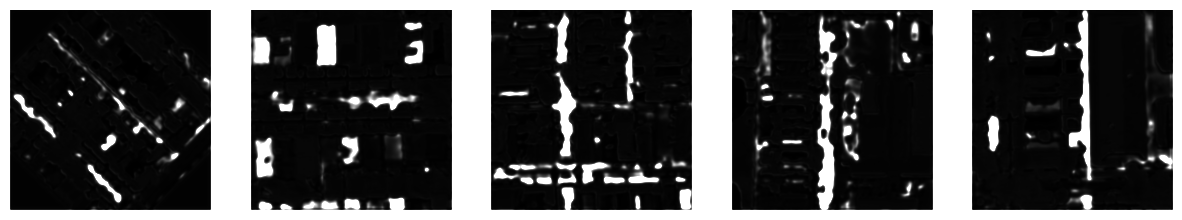

In [23]:
import matplotlib.pyplot as plt
predicted_images = outputs.cpu().detach()

# Binarize the images

# Visualize the first N images of the batch
N = 5  # Number of images you want to display
fig, axes = plt.subplots(1, N, figsize=(15, 3))
for i in range(N):
    img = predicted_images[i].squeeze().numpy()  # Assuming grayscale
    axes[i].imshow(img, cmap='gray', vmin=0, vmax=0.1)
    axes[i].axis('off')
plt.show()

In [24]:
for i, img in enumerate(predicted_images):
    min_value = img.min().item()
    max_value = img.max().item()
    print(f"Image {i}: Min value = {min_value}, Max value = {max_value}")


Image 0: Min value = 5.732010322390124e-05, Max value = 0.40301263332366943
Image 1: Min value = 0.00016419970779679716, Max value = 0.4161342978477478
Image 2: Min value = 6.271426536841318e-05, Max value = 0.4181022644042969
Image 3: Min value = 3.1613984901923686e-05, Max value = 0.4104037284851074
Image 4: Min value = 0.00010253854998154566, Max value = 0.41761744022369385
Image 5: Min value = 8.738842734601349e-05, Max value = 0.4166114330291748
Image 6: Min value = 0.00016855179273989052, Max value = 0.4180196225643158
Image 7: Min value = 0.00013095347094349563, Max value = 0.4230622947216034
Image 8: Min value = 0.0001501240039942786, Max value = 0.4185197949409485
Image 9: Min value = 0.00016135629266500473, Max value = 0.41301429271698
Image 10: Min value = 0.0001966964191524312, Max value = 0.42334070801734924
Image 11: Min value = 4.1823026549536735e-05, Max value = 0.4166105389595032
Image 12: Min value = 4.8188408982241526e-05, Max value = 0.4206862449645996
Image 13: Min

In [29]:
inputs[0].shape

torch.Size([3, 400, 400])

In [37]:
def visualize_batch(num_images=5):
        fig, axs = plt.subplots(num_images, 2, figsize=(10, num_images * 3))

        for i in range(num_images):
            img, mask = train_data[i]
            img, mask = img.numpy().transpose(1, 2, 0), mask.numpy().squeeze()

            axs[i, 0].imshow(img)
            axs[i, 0].set_title('Image')
            axs[i, 0].axis('off')

            axs[i, 1].imshow(mask, cmap='gray')
            axs[i, 1].set_title('Mask')
            axs[i, 1].axis('off')


        plt.tight_layout()
        plt.show()

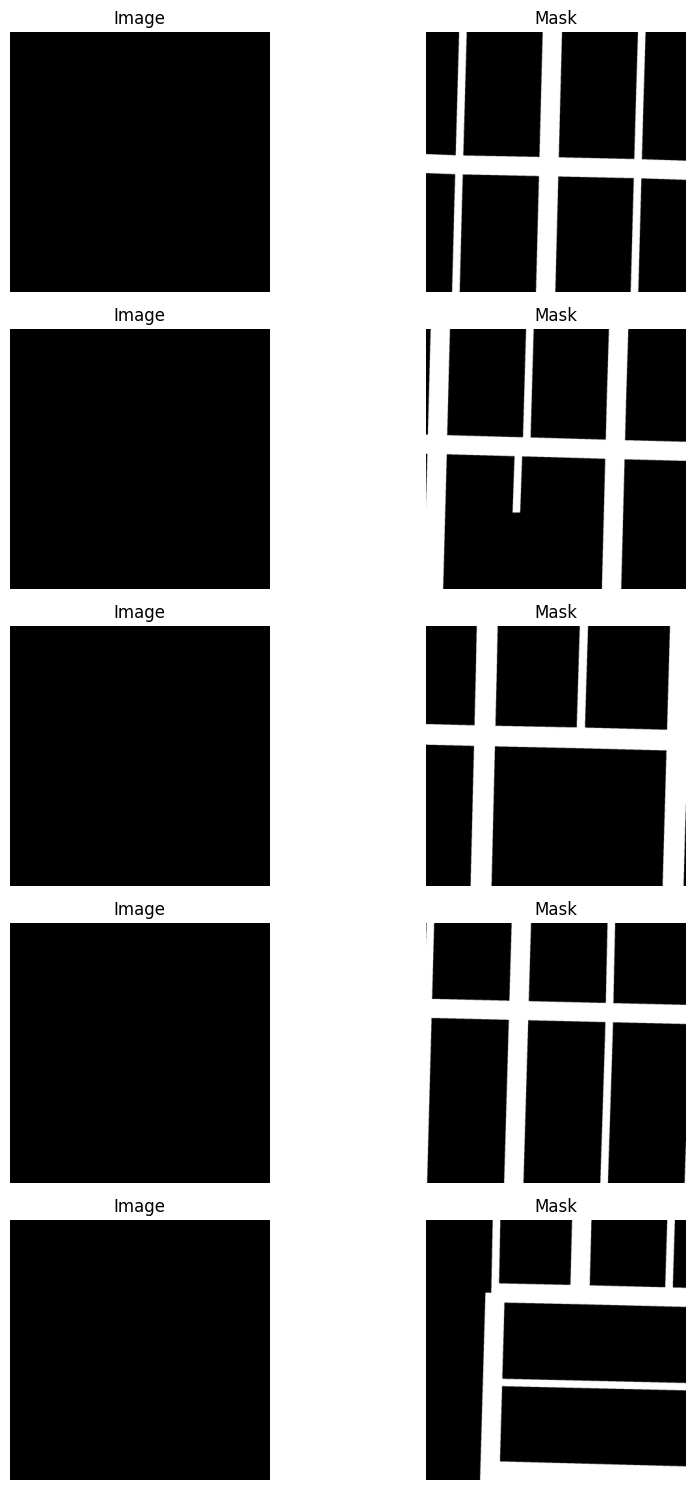

In [38]:
visualize_batch()